In [1]:
import numpy as np
import pandas as pd

In [2]:
#load all the data files
agency = pd.read_csv('agency.txt')
calendar = pd.read_csv('calendar.txt')
routes = pd.read_csv('routes.txt')
shapes = pd.read_csv('shapes.txt')
stop_times = pd.read_csv('stop_times.txt')
stops = pd.read_csv('stops.txt')
trips = pd.read_csv('trips.txt')

#show the first few rows and the stuture of each dataframe
data_overviews = {
    "agency": agency.head(),
    "calendar": calendar.head(),
    "routes": routes.head(),
    "shapes": shapes.head(),
    "stop_time": stop_times.head(),
    "stops": stops.head(),
    "trips": trips.head()

}
data_overviews
                                 

{'agency':   agency_id                   agency_name                      agency_url  \
 0      DMRC  Delhi Metro Rail Corporation  http://www.delhimetrorail.com/   
 
   agency_timezone  agency_lang  agency_phone  agency_fare_url  agency_email  
 0    Asia/Kolkata          NaN           NaN              NaN           NaN  ,
 'calendar':   service_id  monday  tuesday  wednesday  thursday  friday  saturday  sunday  \
 0    weekday       1        1          1         1       1         0       0   
 1   saturday       0        0          0         0       0         1       0   
 2     sunday       0        0          0         0       0         0       1   
 
    start_date  end_date  
 0    20190101  20251231  
 1    20190101  20251231  
 2    20190101  20251231  ,
 'routes':    route_id  agency_id route_short_name  \
 0        33        NaN           R_SP_R   
 1        31        NaN           G_DD_R   
 2        29        NaN           P_MS_R   
 3        12        NaN             M_JB

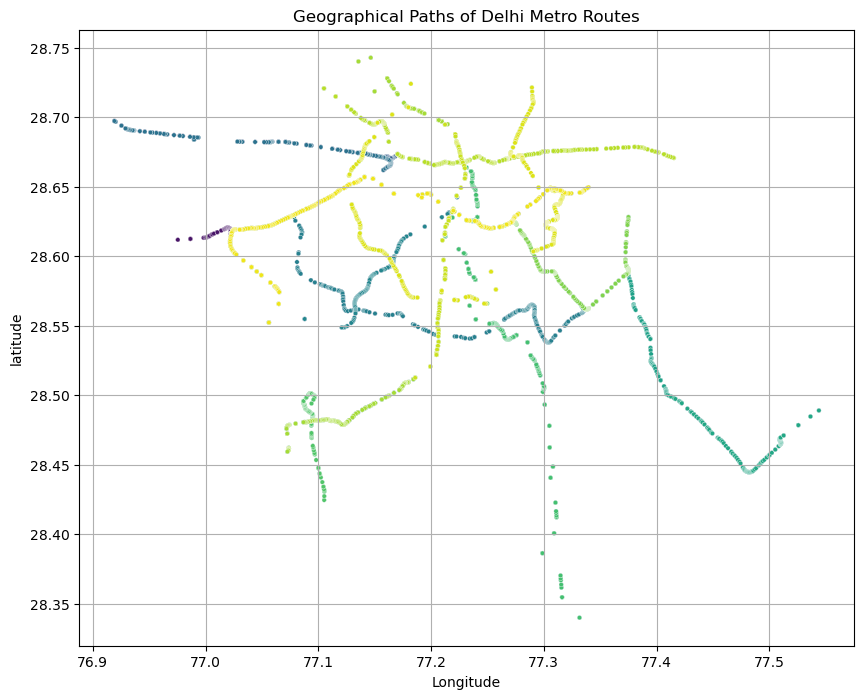

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize=(10,8))
sns.scatterplot(x='shape_pt_lon' , y='shape_pt_lat', hue='shape_id', data=shapes, palette='viridis', s=10, legend=None)
plt.title('Geographical Paths of Delhi Metro Routes')
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.grid(True)
plt.show()

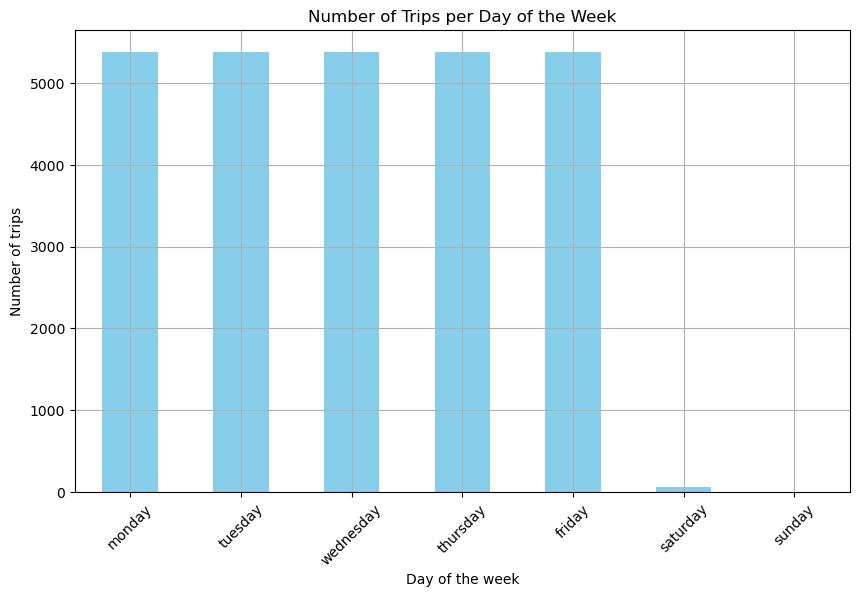

In [4]:
#merge trips with  calendar to include the day of opertion information
trips_calendar = pd.merge(trips, calendar, on='service_id', how ='left')

# count the number of trips per day of the week
trip_counts = trips_calendar[['monday','tuesday','wednesday','thursday', 'friday', 'saturday', 'sunday']].sum()

#plotting

plt.figure(figsize=(10,6))
trip_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Trips per Day of the Week')
plt.xlabel('Day of the week')
plt.ylabel('Number of trips')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

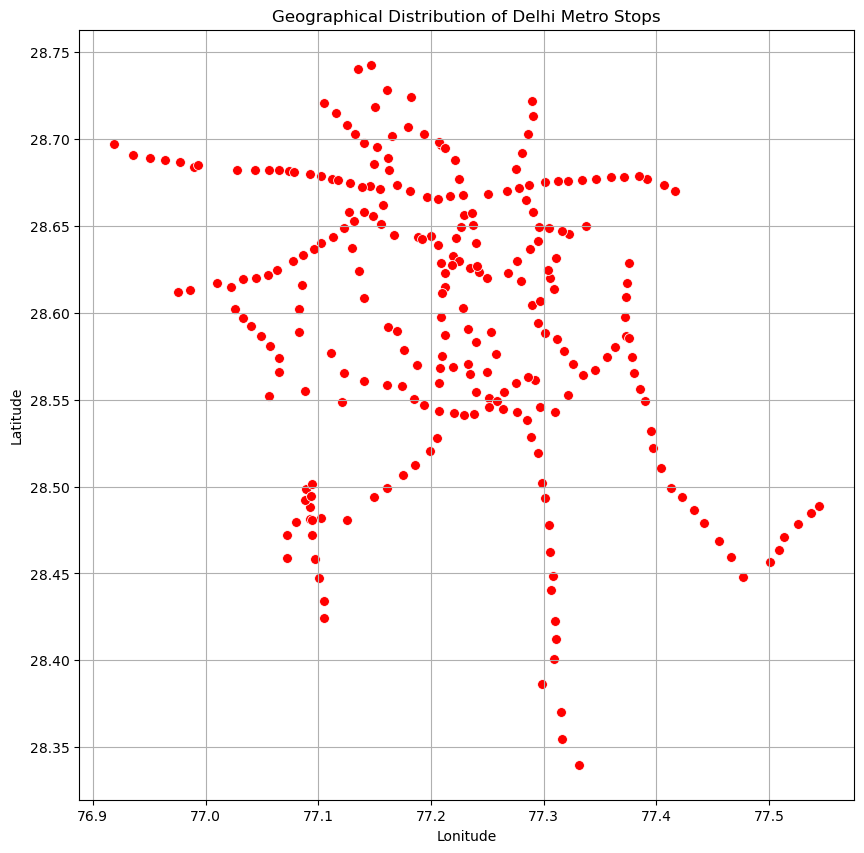

In [5]:
#plottting the locations of the stops
plt.figure(figsize=(10,10))
sns.scatterplot(x='stop_lon', y='stop_lat', data=stops, color='red', s=50, marker='o')
plt.title('Geographical Distribution of Delhi Metro Stops')
plt.xlabel('Lonitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

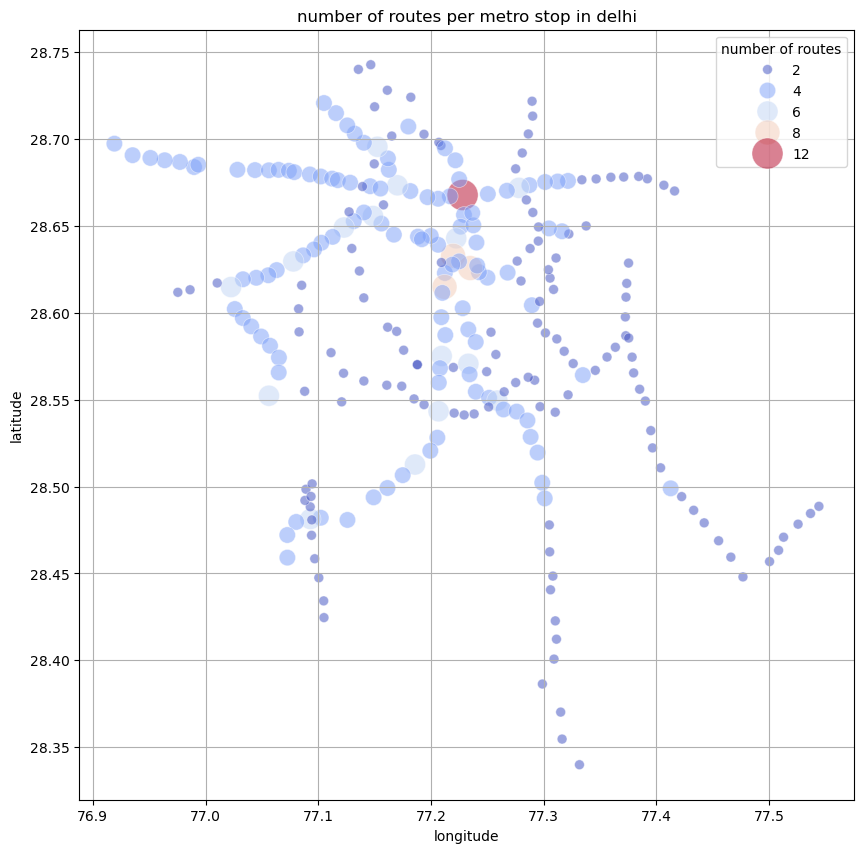

In [6]:
# merg stops with stop_times to link each stop with trips, and then merge with trips to get route information
stops_with_routes = pd.merge(pd.merge(stop_times,trips, on = 'trip_id'), routes, on ='route_id')

# count how many unique routes pass through each stop
stop_route_counts = stops_with_routes.groupby('stop_id')['route_id'].nunique().reset_index()
stop_route_counts = stop_route_counts.rename(columns={'route_id': 'number_of_routes'})

#merge this with stops to get the names and location for plotting
stop_route_counts = pd.merge(stop_route_counts, stops, on='stop_id')

#plot the number of routes per stop
plt.figure(figsize=(10,10))
sns.scatterplot(x='stop_lon', y='stop_lat', size='number_of_routes', hue='number_of_routes', sizes=(50, 500), alpha=0.5, palette='coolwarm', data=stop_route_counts)
plt.title('number of routes per metro stop in delhi')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend(title='number of routes')
plt.grid(True)
plt.show()

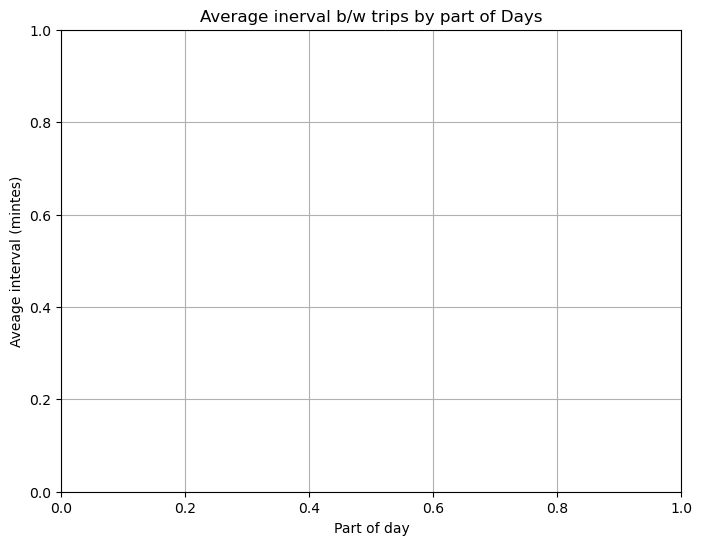

In [7]:
# converting stop_times 'arrival_time from string to datetime.time for easier manipulation
import datetime as dt

#function to convert time string to datetime.time
def convert_to_time(time_str):
    try:
        return dt.datetime.strptime(time_str, '%H:%M:%S').time()
    except ValueError:

        hour, minute, second = map(int, time_str.split(':'))
        return dt.time(hour % 24, minute, second)

stop_times['arrival_time_dt'] = stop_times['arrival_time'].apply(convert_to_time)

#calculate the difference in arrival time for subsequent trips at each stop
stop_times_sorted = stop_times.sort_values(by=['stop_id', 'arrival_time_dt'])
stop_times_sorted['next_arrival_time'] = stop_times_sorted.groupby('stop_id')['arrival_time_dt'].shift(-1)

#function to calculate the difference in minutes b/w two times
def time_difference(time1, time2):
    if pd.isna(time1) or pd.isna(time2):
        return None
        full_date_time1 = dt.datetime.comdine(dt.date.today(), time1)
        full_date_time2 = dt.datetime.comdine(dt.date.today(), time2)
        return (fill_date_time2 -full_date_time1).seconds /60 
stop_times_sorted['interval_minutes'] = stop_times_sorted.apply(lambda row: time_difference(row['arrival_time_dt'], row['next_arrival_time']), axis=1)

   # drop nan  values from interval (last trips of the day)
stop_times_intervals = stop_times_sorted.dropna(subset=['interval_minutes'])

# averg interval by time of days
def part_of_day(time):
    if time < dt.time(12, 0):
        return 'Morning'
    elif time < dt.time(17, 0):
        return 'Afternoon'
    else:
        return 'Evening'

stop_times_intervals['part_of_day'] = stop_times_intervals['arrival_time_dt'].apply(part_of_day)
average_intervals = stop_times_intervals.groupby('part_of_day')['interval_minutes'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='part_of_day' , y='interval_minutes', data=average_intervals, order=['Morning', 'Afternoon', ' Evening'], palette='mako')
plt.title('Average inerval b/w trips by part of Days')
plt.xlabel('Part of day')
plt.ylabel('Aveage interval (mintes)')
plt.grid(True)
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_6464\510036315.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='time_interval', y='number_of_trips', data=trips_per_interval, palette='Set2')


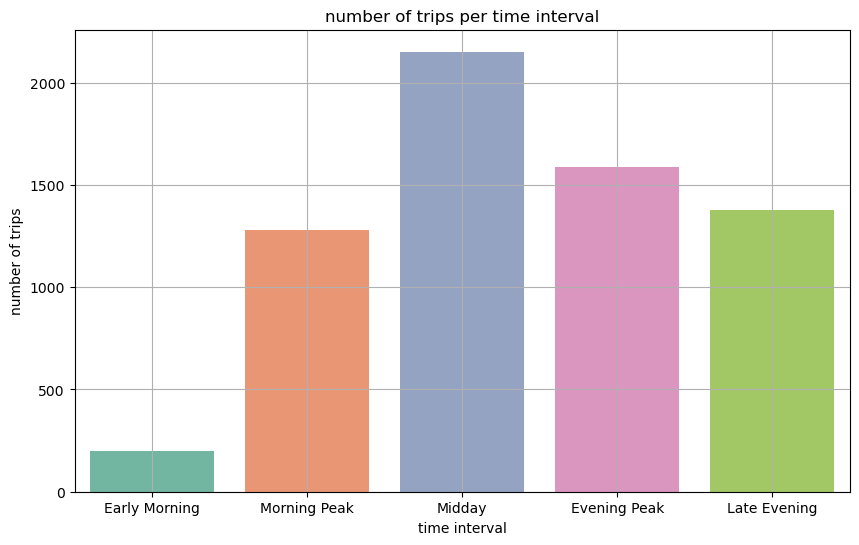

In [8]:
#define time intervals for classification
def classify_time_interval(time):
    if time < dt.time(6, 0):
        return 'Early Morning'
    elif time < dt.time(10, 0):
        return 'Morning Peak'
    elif time < dt.time(16, 0):
        return 'Midday'
    elif time < dt.time(20, 0):
        return 'Evening Peak'
    else:
        return 'Late Evening'

#apply time interval classification 
stop_times['time_interval'] = stop_times['arrival_time_dt'].apply(classify_time_interval)


# count the number of trips per time interval
trips_per_interval = stop_times.groupby('time_interval')['trip_id'].nunique().reset_index()
trips_per_interval = trips_per_interval.rename(columns={'trip_id':'number_of_trips'})

#sorting te dataframe
ordered_intervals =['Early Morning', 'Morning Peak', 'Midday', 'Evening Peak', 'Late Evening']
trips_per_interval['time_interval'] = pd.Categorical(trips_per_interval['time_interval'], categories=ordered_intervals, ordered=True)
trips_per_interval = trips_per_interval.sort_values('time_interval') 

#ploting the number of trips per time interval
plt.figure(figsize=(10, 6))
sns.barplot(x='time_interval', y='number_of_trips', data=trips_per_interval, palette='Set2')
plt.title('number of trips per time interval')
plt.xlabel('time interval')
plt.ylabel('number of trips')
plt.grid(True)
plt.show()
           



let calculate  and visualize  

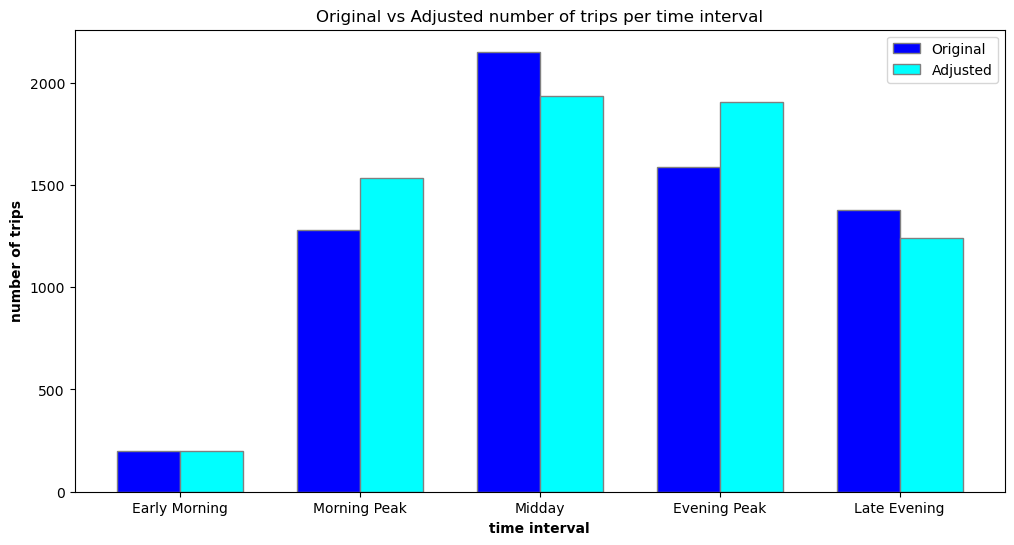

In [9]:
#adjusting frequence basedon hypothetical scenario 
adjusted_trips_per_interval = trips_per_interval.copy()
adjustment_factors = {'Morning Peak' : 1.20, 'Evening Peak': 1.20, 'Midday': 0.90, 'Early Morning': 1.0, 'Late Evening': 0.90}

#apply the adjustments
adjusted_trips_per_interval['adjusted_number_of_trips'] = adjusted_trips_per_interval.apply(
    lambda row: int(row['number_of_trips'] * adjustment_factors[row['time_interval']]), axis=1)

#plotting original vs adjusted number of trips per time interval
plt.figure(figsize=(12, 6))
bar_width =0.35
r1 = range(len(adjusted_trips_per_interval))
r2 = [x + bar_width for x in r1]

plt.bar(r1, adjusted_trips_per_interval['number_of_trips'], color='blue', width=bar_width, edgecolor='grey', label='Original')
plt.bar(r2, adjusted_trips_per_interval['adjusted_number_of_trips'], color='cyan', width=bar_width, edgecolor='grey', label='Adjusted')

plt.xlabel('time interval', fontweight='bold')
plt.ylabel('number of trips', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(adjusted_trips_per_interval))], adjusted_trips_per_interval['time_interval'])
plt.title('Original vs Adjusted number of trips per time interval')
plt.legend()

plt.show()

summary

Metro Operations Optimization refers to the systematic process of enhancing the efficiency, reliability, and effectiveness of Metro services through various data-driven techniques and operational adjustments. Our approach to optimizing metro operations showcases how analyzing existing data can guide decisions in real-time scheduling adjustments, even in the absence of explicit passenger count data.